# Brain Tumor Detection

### For Google Colab Users

In [ ]:
#@title ## Mount Your Google Drive & Map your Directory
#@markdown Please run this cell (`Ctrl+Enter` or `Shift+Enter`) and follow the steps printed bellow.
import os

from google.colab import drive
drive.mount('/content/gdrive')

# check Google Drive is mounted
if not os.path.isdir("/content/gdrive"):
  raise FileNotFoundError("Your Google Drive isn't mounted. Please run the above cell.")

assignment_dir = "/content/gdrive/MyDrive/workspace/BrainTumorDetection"  #@param{type:"string"}
assignment_dest = "/content/project"

# create symbolic link
!rm -f {assignment_dest}
!ln -s "{assignment_dir}" "{assignment_dest}"
print(f'Succesfully mapped (ln -s) "{assignment_dest}" -> "{assignment_dir}"')

# cd to linked dir
%cd -q {assignment_dest}
print(f'Succesfully changed directory (cd) to "{assignment_dest}"')

Mounted at /content/gdrive
Succesfully mapped (ln -s) "/content/project" -> "/content/gdrive/MyDrive/workspace/BrainTumorDetection"
Succesfully changed directory (cd) to "/content/project"


### Init

In [1]:
#@title ##Init

#@markdown Import required modules and observe your resources

# auto reload
%load_ext autoreload
%autoreload 2

# import
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import wandb
wandb.login()

from experiment import Experiment
from post_process import get_masks_from_heatmaps
from data import DataGenerator, SegmentationGenerator

# Show resources
!nvidia-smi

wandb: Currently logged in as: antebi-itai (use `wandb login --relogin` to force relogin)


Thu Jul  8 23:32:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:85:00.0 Off |                    0 |
| N/A   38C    P0    41W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Experiment

In [9]:
# params
config = {
"model_name": "vgg19",
#"model_name": "vgg11",
"data_train_path": os.path.join(".", "Data", "Training"),
#"data_test_class": DataGenerator,         "data_test_path": os.path.join(".", "Data", "Testing"),
"data_test_class": SegmentationGenerator, "data_test_path": os.path.join(".", "SegmentationData", "train"),     "mri_type": "T1c", 
"epochs": 2,
"train_batch_size": 100,
"lr": 1e-4,
"heatmap_batch_size": 256,
"occlusion_size": (60,60),
"heat_layers" : [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34],
#"heat_layers" : [0, 3, 6, 8, 11, 13, 16, 18],
"heatmap_threshold" : 0.80,
"shuffle_data": True,
"device": "cuda"
}

with wandb.init(project="BrainTumorDetection", config=config):
    ### load best model
    experiment = Experiment(config)
    print("Model's accuracy: ", "{:.2f}".format(experiment.eval_model()), flush=True)
    #experiment.train_model()
    #print("Model's accuracy: ", "{:.2f}".format(experiment.eval_model()), flush=True)
    
    for image_num in [1, 3, 10, 11, 12, 13, 14, 15]:
        image_path = r"./Data/Testing/glioma_tumor/image({image_num}).jpg".format(image_num=image_num)
        ### generate heatmaps
        # heatmaps = experiment.generate_heatmap(image_path)
        ### calculate masks
        # hot_masks, cold_masks = get_masks_from_heatmaps(heatmaps, thresh=config["heatmap_threshold"], smallest_contour_len=30)

wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


loading vgg19 model...
loading best model state from: ./Models/vgg19.pth
Model's accuracy:  0.47


Test/accuracy/no,0.54167
_runtime,30
_timestamp,1625777258
_step,8
Test/accuracy/yes,0.69231
Test/accuracy,0.59459


Test/accuracy/no,▁▇█
_runtime,▁▁▁▅▅▅███
_timestamp,▁▁▁▅▅▅███
_step,▁▂▃▄▅▅▆▇█
Test/accuracy/yes,█▁▂
Test/accuracy,█▁▄


is_tumor 0


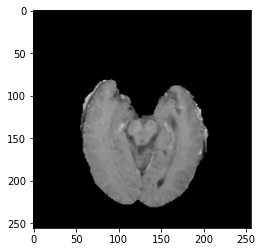

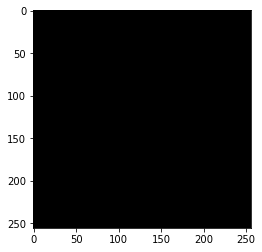

In [30]:
from matplotlib import pyplot as plt

image_num = 100

def display(array, gray=False):
    cmap = "gray" if gray else None
    if len(array.shape) == 3:
        array = array.permute(1, 2, 0)
    plt.figure()
    plt.imshow(array, cmap=cmap)

mri, (seg, is_tumor) = experiment.test_dataset[image_num]
print("is_tumor", is_tumor)
display(mri)
display(seg, gray=True)
